In [1]:
import numpy as np
import tensorflow as tf
import os
import struct
from sklearn.neighbors import KNeighborsClassifier
from six.moves import cPickle
from utils import *
import matplotlib.pyplot as plt
%matplotlib inline


In [2]:
d = 20 #latent dimension
n_hidden = 500 # hidden units
lr = 0.001 # learning rate
beta_reg = 1.0 # for beta-VAE, 1.0 corresponds to usual VAE
gamma = 0.0 # warping parameter
N = 60000 # number of train samples in MNIST
N_test = 10000 # number of test samples in MNIST
batch_size = 50
max_epochs = 1 # number of epochs used for training


In [3]:
max_epochs = 100

In [4]:
# VAE IMPLEMENTATION
tf.reset_default_graph()

eps = tf.placeholder(tf.float32, shape=(None, d))  # variables to reparametrize to sample from approx posterior
z_gen = tf.placeholder(tf.float32, shape=(None, d))  # used only for generative samples (samples from prior)
X = tf.placeholder(tf.float32, shape=(None, 784))
labels = tf.placeholder(tf.float32, shape=(None, 10))
# the following two placeholders should be obtained by running the graph and generating samples from the model
# they are used to compute the inception score
class_distr_gen = tf.placeholder(tf.float32, shape=(10))  # this is intended to be the generative label distribution
X_gen = tf.placeholder(tf.float32, shape=(None, 784))  # these are generated samples
keep_prob = tf.placeholder(tf.float32, name='keep_prob')

with tf.variable_scope('ELBO', reuse=tf.AUTO_REUSE):
    mu_Z, sigma_Z = encoder_mnist(X, n_hidden, d, keep_prob)
Z = mu_Z + sigma_Z * eps  # [batch_size, d]

with tf.variable_scope('ELBO', reuse=tf.AUTO_REUSE):
    alpha_X, beta_X = decoder_mnist_beta(Z, n_hidden, 784, keep_prob)
    # sample from the model
    alpha_X_gen, beta_X_gen = decoder_mnist_beta(z_gen, n_hidden, 784, keep_prob)

clipped_X = tf.clip_by_value(X, 1e-4, 1 - 1e-4)
log_norm_const = tf.lgamma(alpha_X + beta_X) - tf.lgamma(alpha_X) - tf.lgamma(beta_X)
log_p_all = tf.reduce_sum((alpha_X - 1.0) * tf.log(clipped_X) + (beta_X - 1.0) * tf.log(1.0 - clipped_X)
                          + log_norm_const, 1)
log_p = tf.reduce_mean(log_p_all)
# computing an IW estimate of the log likelihood requires having k epsilon samples per data point in the batch,
# so that eps would have to be shaped [None, d, k], which would complicate the rest of the graph.
# since trainin with IWAE is not required here, only the log importance weights are computed in the graph and the
# log likelihood estimate is computed outside the graph by calling it several times for the same batch but with
# different random epsilons.
log_iw = log_p_all + tf.reduce_sum(-0.5 * tf.square(Z), 1)
log_iw = log_iw + tf.reduce_sum(tf.log(1e-8 + sigma_Z) + tf.square(mu_Z - Z) / (2.0 * tf.square(sigma_Z)), 1)

KL = 0.5 * tf.reduce_sum(tf.square(mu_Z) + tf.square(sigma_Z) - tf.log(1e-8 + tf.square(sigma_Z)) - 1.0, 1)
KL = tf.reduce_mean(KL)

ELBO = log_p - beta_reg * KL
cost = - ELBO

log_p_all_cheat = tf.reduce_sum((alpha_X - 1.0) * tf.log(clipped_X) + (beta_X - 1.0) * tf.log(1.0 - clipped_X), 1)
log_p_cheat = tf.reduce_mean(log_p_all_cheat)
ELBO_cheat = log_p_cheat - beta_reg * KL
cost_cheat = - ELBO_cheat
log_iw_cheat = log_iw - log_p_all + log_p_all_cheat

with tf.variable_scope('classifier', reuse=tf.AUTO_REUSE):
    class_logits = classifier_mnist(X, n_hidden, 10, keep_prob)
    class_logits_gen = classifier_mnist(X_gen, n_hidden, 10, keep_prob)
acc = 1.0 - tf.reduce_mean(tf.abs(tf.sign(tf.cast(tf.argmax(class_logits, 1) - tf.argmax(labels, 1), tf.float32))))
class_loss = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits_v2(logits=class_logits, labels=labels))
class_probs_gen = tf.clip_by_value(tf.nn.softmax(class_logits_gen), 1e-4, 1 - 1e-4)
is_kl = tf.reduce_sum(class_probs_gen * (tf.log(class_probs_gen) - tf.log(class_distr_gen)), axis=1)
log_is = tf.reduce_mean(is_kl)

optim = tf.train.AdamOptimizer(learning_rate=lr)
all_params_ELBO = tf.trainable_variables(scope='ELBO')
grads_and_vars = optim.compute_gradients(cost, all_params_ELBO)
clipped_grads_and_vars = [(tf.clip_by_value(grad, -1.0, 1.0), var) for grad, var in grads_and_vars]
optimizer = optim.apply_gradients(clipped_grads_and_vars)

optim_cheat = tf.train.AdamOptimizer(learning_rate=lr)
grads_and_vars_cheat = optim_cheat.compute_gradients(cost_cheat, all_params_ELBO)
clipped_grads_and_vars_cheat = [(tf.clip_by_value(grad, -1.0, 1.0), var) for grad, var in grads_and_vars_cheat]
optimizer_cheat = optim_cheat.apply_gradients(clipped_grads_and_vars_cheat)

optim_class = tf.train.AdamOptimizer(learning_rate=lr)
all_params_class = tf.trainable_variables(scope='classifier')
grads_and_vars_class = optim.compute_gradients(class_loss, all_params_class)
clipped_grads_and_vars_class = [(tf.clip_by_value(grad, -1.0, 1.0), var) for grad, var in grads_and_vars_class]
optimizer_class = optim_class.apply_gradients(clipped_grads_and_vars_class)

init_op = tf.global_variables_initializer()
sess = tf.Session()


In [5]:
# HELPER FUNCTIONS TO EVALUATE METRICS ONCE THE MODEL IS TRAINED

def epoch_metrics(N, d, batch_size, X_eval, k=100):
    assert np.shape(X_eval)[0] % batch_size == 0
    ELBO_val = 0.0
    ELBO_cheat_val = 0.0
    IW_ELBO = 0.0
    IW_cheat = 0.0
    local_perms = PermManager(np.shape(X_eval)[0], batch_size)
    while local_perms.epoch < 1:
        eps_batch = np.random.normal(size=[batch_size, d])
        batch = local_perms.get_indices()
        X_batch = np.reshape(X_eval[batch, :], [batch_size, -1])
        ELBO_val_batch, ELBO_cheat_val_batch = sess.run([ELBO, ELBO_cheat], {eps: eps_batch, X: X_batch, keep_prob: 1.0})
        ELBO_val += ELBO_val_batch
        ELBO_cheat_val += ELBO_cheat_val_batch
        increase_IW_ELBO = []
        increase_IW_cheat = []
        for i in xrange(k):
            eps_batch = np.random.normal(size=[batch_size, d])
            inc_IW_ELBO, inc_IW_cheat = sess.run([log_iw, log_iw_cheat], {eps: eps_batch, X: X_batch, keep_prob: 1.0})
            increase_IW_ELBO.append(inc_IW_ELBO)
            increase_IW_cheat.append(inc_IW_cheat)
        increase_IW_ELBO = np.array(increase_IW_ELBO)
        a_ELBO = np.max(increase_IW_ELBO, axis=0)
        IW_ELBO += np.mean(a_ELBO + np.log(np.sum(np.exp(increase_IW_ELBO - a_ELBO), 0)) - np.log(k))
        increase_IW_cheat = np.array(increase_IW_cheat)
        a_cheat = np.max(increase_IW_cheat, axis=0)
        IW_cheat += np.mean(a_cheat + np.log(np.sum(np.exp(increase_IW_cheat - a_cheat), 0)) - np.log(k))
    ELBO_val = ELBO_val * batch_size / N
    ELBO_cheat_val = ELBO_cheat_val * batch_size / N
    IW_ELBO = IW_ELBO * batch_size / N
    IW_cheat = IW_cheat * batch_size / N
    del local_perms
    return ELBO_val, ELBO_cheat_val, IW_ELBO, IW_cheat


def compute_IS(batch_size, samples):
    # computes the inception score using samples
    N_samples = np.shape(samples)[0]
    class_distr_val = np.zeros(10)
    local_perms = PermManager(N_samples, batch_size)
    while local_perms.epoch < 1:
        batch = local_perms.get_indices()
        samples_batch = np.reshape(samples[batch], [batch_size, -1])
        class_distr_val += np.sum(sess.run(class_probs_gen, {X_gen: samples_batch, keep_prob: 1.0}), axis=0)
    class_distr_val = class_distr_val / N_samples
    log_is_val = 0.0
    local_perms = PermManager(N_samples, batch_size)
    while local_perms.epoch < 1:
        batch = local_perms.get_indices()
        samples_batch = np.reshape(samples[batch], [batch_size, -1])
        log_is_val += sess.run(log_is, {X_gen: samples_batch, class_distr_gen: class_distr_val, keep_prob:1.0})
    log_is_val = log_is_val * batch_size / N
    is_val = np.exp(log_is_val)
    return is_val


def sample_from_model_beta(batch_size, N):
    # gives back N samples from the model
    assert N % batch_size == 0
    K = N / batch_size
    samples_alpha = []
    samples_beta = []
    for i in xrange(K):
        alpha_batch, beta_batch = sess.run([alpha_X_gen, beta_X_gen], {z_gen: np.random.normal(size=[batch_size, d]), keep_prob: 1.0})
        samples_alpha.append(alpha_batch)
        samples_beta.append(beta_batch)
    return np.concatenate(samples_alpha), np.concatenate(samples_beta)


def k_nn_acc(k, batch_size, X_eval, digits_eval, X_train, digits_train):
    # computes the knn metric from the model's latent variables
    assert np.shape(X_eval)[0] % batch_size == 0
    assert np.shape(X_eval)[0] == np.shape(digits_eval)[0]
    assert np.shape(X_train)[0] % batch_size == 0
    assert np.shape(X_train)[0] == np.shape(digits_train)[0]
    local_perms = PermManager(np.shape(X_train)[0], batch_size, perm=np.arange(np.shape(X_train)[0]))
    mu_vals_train = []
    while local_perms.epoch < 1:
        batch = local_perms.get_indices()
        X_batch = np.reshape(X_train[batch, :], [batch_size, -1])
        mu_vals_train.append(sess.run(mu_Z, {X: X_batch, keep_prob: 1.0}))
    mu_vals_train = np.concatenate(mu_vals_train)
    classifier = KNeighborsClassifier(n_neighbors=k)
    classifier.fit(mu_vals_train, digits_train)
    local_perms = PermManager(np.shape(X_eval)[0], batch_size, perm=np.arange(np.shape(X_eval)[0]))
    mu_vals_eval = []
    while local_perms.epoch < 1:
        batch = local_perms.get_indices()
        X_batch = np.reshape(X_eval[batch, :], [batch_size, -1])
        mu_vals_eval.append(sess.run(mu_Z, {X: X_batch, keep_prob: 1.0}))
    mu_vals_eval = np.concatenate(mu_vals_eval)
    digit_pred = classifier.predict(mu_vals_eval)
    del local_perms
    return float(np.sum(digit_pred == digits_eval)) / np.shape(X_eval)[0]

In [6]:
# LOAD AND WARP MNIST
train_img, train_digits = read_mnist(path='./mnist/')
test_img, test_digits = read_mnist(dataset='testing', path='./mnist/')
train_img = (np.array(train_img, dtype='float32') + np.array(np.random.random((60000, 28, 28)),
                                                             dtype='float32')) / 256.0
train_img = warp(train_img, gamma)
test_img = (np.array(test_img, dtype='float32') + np.array(np.random.random((10000, 28, 28)),
                                                           dtype='float32')) / 256.0
test_img = warp(test_img, gamma)
train_lbl = make_one_hot(train_digits, 10)
test_lbl = make_one_hot(test_digits, 10)


In [ ]:
# TRAIN CLASSIFIER (USED TO COMPUTE INCEPTION SCORES)

sess.run(init_op)

perms = PermManager(N, batch_size)
while True:
    start_epoch = perms.epoch
    batch = perms.get_indices()
    X_batch = np.reshape(train_img[batch, :], [batch_size, -1])
    labels_batch = train_lbl[batch]
    _, c = sess.run([optimizer_class, class_loss], {X: X_batch, labels: labels_batch, keep_prob: 0.9})
    if perms.epoch >= max_epochs:
        break
        

In [7]:
# TRAIN BETA DISTRIBUTION VAE

sess.run(init_op)  # uncomment to restart variables

perms = PermManager(N, batch_size)
while True:
    start_epoch = perms.epoch
    eps_batch = np.random.normal(size=[batch_size, d])
    batch = perms.get_indices()
    X_batch = np.reshape(train_img[batch, :], [batch_size, -1])
    _, c = sess.run([optimizer, cost], {eps: eps_batch, X: X_batch, keep_prob: 0.9})
    if perms.epoch >= max_epochs:
        break
        

In [ ]:
# epoch metrics computes ELBOs and log likelihoods, both including and ignoring normalizing constants
print epoch_metrics(N_test, d, batch_size, test_img)


In [ ]:
# compute the knn metric to measure usefulness of latents
print k_nn_acc(15, batch_size, test_img, test_digits, train_img, train_digits)


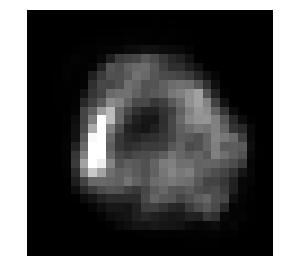

In [8]:
# SHOW MODEL SAMPLES

ind = 0
samples = sample_from_model_beta(100, 100)

plt.figure(figsize=(4, 4))
plt.imshow(np.reshape(samples[0][ind] / (samples[1][ind] + samples[1][ind]), [28, 28]), norm=None, vmin=0.0, vmax=1.0,
           cmap='gray')
plt.axis('off')
plt.tight_layout()


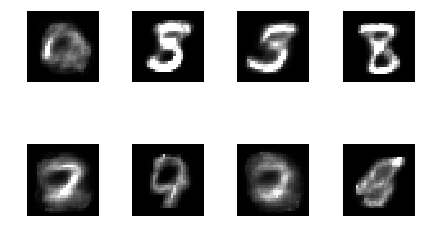

In [11]:
for i in range(8):
    plt.subplot(241 + i)
    plt.imshow(np.reshape(samples[0][i] / (samples[1][i] + samples[1][i]), [28, 28]), 
               norm=None, vmin=0.0, vmax=1.0, cmap='gray')
    plt.axis('off')
plt.tight_layout()
plt.show()

In [ ]:
# COMPUTE INCEPTION SCORES

samples = sample_from_model_beta(batch_size, N)
# uncomment to select which IS to compute
# new_samples = np.reshape(train_img, [N, 784]) # data
new_samples = sample_beta(samples[0], samples[1]) # beta from decoder output
# new_samples = mean_from_params_beta(samples[0], samples[1]) # decoder output (mean)

print compute_IS(batch_size, new_samples)


In [ ]:
# TRAIN BETA DISTRIBUTION VAE WHILE IGNORING THE NORMALIZING CONSTANT

sess.run(init_op)  # uncomment to restart variables, should be done if regular beta distr VAE was previously trained

perms = PermManager(N, batch_size)
while True:
    start_epoch = perms.epoch
    eps_batch = np.random.normal(size=[batch_size, d])
    batch = perms.get_indices()
    X_batch = np.reshape(train_img[batch, :], [batch_size, -1])
    _, c = sess.run([optimizer_cheat, cost_cheat], {eps: eps_batch, X: X_batch, keep_prob: 0.9})
    if perms.epoch >= max_epochs:
        break
        

In [ ]:
print epoch_metrics(N_test, d, batch_size, test_img)


In [ ]:
print k_nn_acc(15, batch_size, test_img, test_digits, train_img, train_digits)


In [ ]:
ind = 0
samples = sample_from_model_beta(100, 100)

plt.figure(figsize=(4, 4))
plt.imshow(np.reshape(samples[0][ind] / (samples[1][ind] + samples[1][ind]), [28, 28]), norm=None, vmin=0.0, vmax=1.0,
           cmap='gray')
plt.axis('off')
plt.tight_layout()


In [ ]:
# NOTE THAT CLASSIFIER SHOULD BE RETRAINED BEFORE RUNNING THIS IF THE BETA DISTR VAE THAT IGNORES THE NORMALIZING
# CONSTANT WAS THE LAST TRAINED ONE

samples = sample_from_model_beta(batch_size, N)
# uncomment to select which IS to compute
# new_samples = np.reshape(train_img, [N, 784]) # data
# new_samples = sample_beta(samples[0], samples[1]) # norm from decoder output
new_samples = mean_from_params_beta(samples[0], samples[1]) # decoder output (mean)

print compute_IS(batch_size, new_samples)
